In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models , layers
from tensorflow.keras.models import load_model
import pickle
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

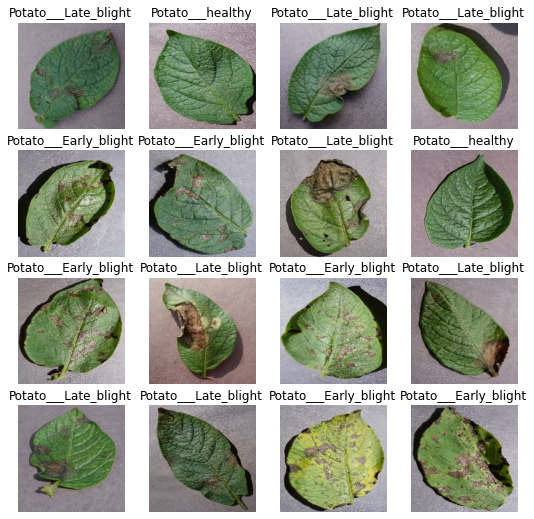

In [6]:
plt.figure(figsize = (9,9))
for image_batch,label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds,train_split=0.8,test_split=0.1,val_split = 0.1,shuffle=True,shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed= 12)
    
    ds_size = len(ds)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds

In [8]:
train_ds,test_ds,val_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(test_ds)

8

In [11]:
len(val_ds)

6

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmantation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmantation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [17]:
model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
)

In [18]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/30
54/54 [==============================] - 105s 2s/step - loss: 0.9070 - accuracy: 0.4855 - val_loss: 0.8324 - val_accuracy: 0.5573
Epoch 2/30
54/54 [==============================] - 102s 2s/step - loss: 0.6575 - accuracy: 0.6823 - val_loss: 0.6457 - val_accuracy: 0.6875
Epoch 3/30
54/54 [==============================] - 103s 2s/step - loss: 0.4138 - accuracy: 0.8258 - val_loss: 0.2039 - val_accuracy: 0.9271
Epoch 4/30
54/54 [==============================] - 102s 2s/step - loss: 0.2825 - accuracy: 0.8895 - val_loss: 0.3149 - val_accuracy: 0.8750
Epoch 5/30
54/54 [==============================] - 102s 2s/step - loss: 0.2238 - accuracy: 0.9034 - val_loss: 0.1971 - val_accuracy: 0.9115
Epoch 6/30
54/54 [==============================] - 102s 2s/step - loss: 0.2027 - accuracy: 0.9149 - val_loss: 0.1731 - val_accuracy: 0.9271
Epoch 7/30
54/54 [==============================] - 103s 2s/step - loss: 0.1460 - accuracy: 0.9427 - val_loss: 0.2422 - val_accuracy: 0.8958
Epoch 8/30
54

In [19]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 500ms/step - loss: 0.0973 - accuracy: 0.9531


In [20]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [23]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

Text(0.5, 1.0, 'Training vs Validation accuracy')

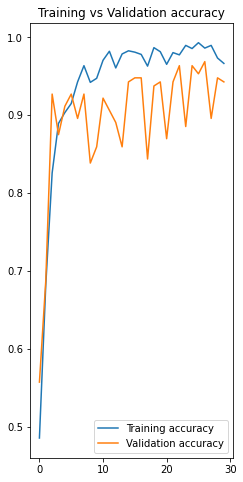

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title("Training vs Validation accuracy")

Text(0.5, 1.0, 'Training vs Validation loss')

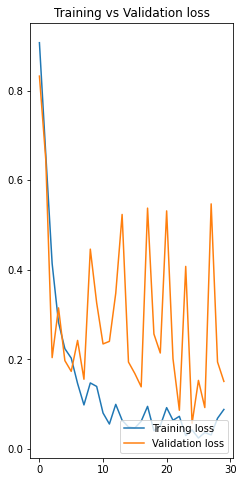

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title("Training vs Validation loss")

In [26]:
history.history

{'loss': [0.907005250453949,
  0.6574625372886658,
  0.41378799080848694,
  0.28252577781677246,
  0.223831906914711,
  0.20273420214653015,
  0.14602071046829224,
  0.09824363142251968,
  0.14729653298854828,
  0.1395021677017212,
  0.08022524416446686,
  0.05556283891201019,
  0.09948042780160904,
  0.06403281539678574,
  0.049003928899765015,
  0.046632297337055206,
  0.061815354973077774,
  0.09499658644199371,
  0.04055473580956459,
  0.05181395635008812,
  0.09217566251754761,
  0.06388252228498459,
  0.07278759777545929,
  0.029857175424695015,
  0.0423896498978138,
  0.024287991225719452,
  0.036653678864240646,
  0.031159356236457825,
  0.0683303251862526,
  0.08810821920633316],
 'accuracy': [0.48553240299224854,
  0.6822916865348816,
  0.8258101940155029,
  0.8894675970077515,
  0.9033564925193787,
  0.9149305820465088,
  0.9427083134651184,
  0.9635416865348816,
  0.9421296119689941,
  0.9473379850387573,
  0.9704861044883728,
  0.9820601940155029,
  0.9606481194496155,
  0

In [27]:
with open("cnn_pickle",'wb') as f:
    pickle.dump(history,f)

In [32]:
with open("cnn_pickle",'rb') as f:
    model = pickle.load(f)

In [29]:
cnn.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [30]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 36ms/step


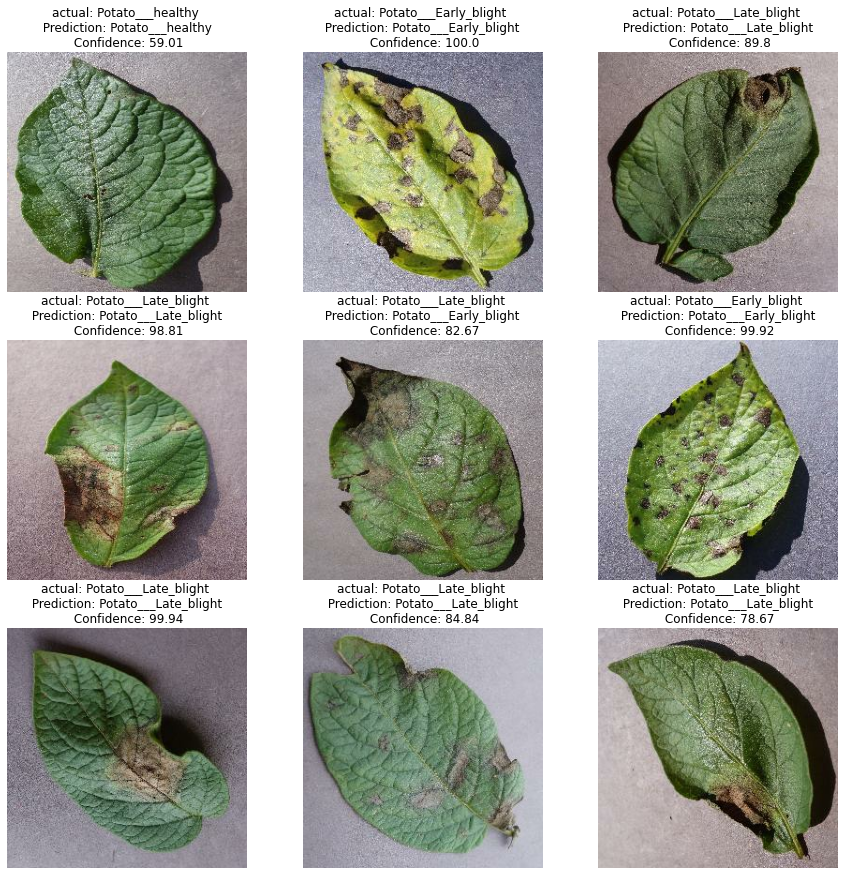

In [31]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i])
        actual_class = class_names[labels[i]]
        
        plt.title(f'actual: {actual_class} \n Prediction: {predicted_class} \n Confidence: {confidence}')
        plt.axis("off")